### This project explores using a Decision Tree model to answer whether variables in a dataset could help in identifying automobile accident risk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import math 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_text
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import eli5

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading only necessary columns to avoid loading all and then deleting many more
df = pd.read_csv("auto_march23.csv", usecols=['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)',
                                              'Humidity(%)', 'Weather_Condition','Sunrise_Sunset'])

Data preparation and exploration

In [3]:
# Sum of observations
df.count().sum()

53564056

In [4]:
# Sum of Nan values to confirm impact of removing Nan values 
df.isna().sum().sum()

534702

In [5]:
# Calculating total % of observations that are Nan to address how
# we will handle Null values
534702 / 53564056

# Null observations are .9% of the observations, so we should be safe to remove these with 
# negatively affecting quantity of usable observations

0.009982477801905068

In [6]:
# Dropping Nan values
df = df.dropna()

In [7]:
# Confirming missing values removed
df.isnull().sum().sum()

0

In [8]:
df['Severity'].value_counts()

2    5975354
3    1262415
4     194062
1      65777
Name: Severity, dtype: int64

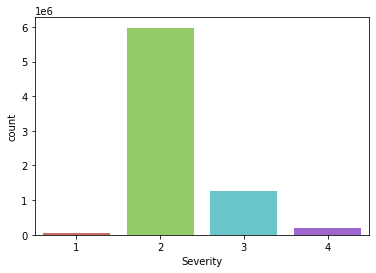

<Figure size 432x288 with 0 Axes>

In [9]:
sns.countplot(x='Severity', data=df, palette='hls')
plt.show()
plt.savefig('Count Plot')

In [10]:
df['Sunrise_Sunset'].value_counts()

Day      5201357
Night    2296251
Name: Sunrise_Sunset, dtype: int64

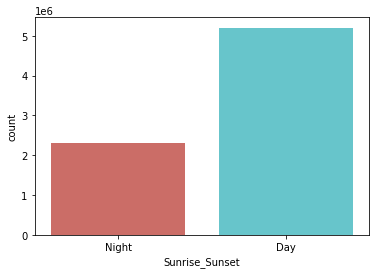

<Figure size 432x288 with 0 Axes>

In [11]:
sns.countplot(x='Sunrise_Sunset', data=df, palette='hls')
plt.show()
plt.savefig('Time of Day')

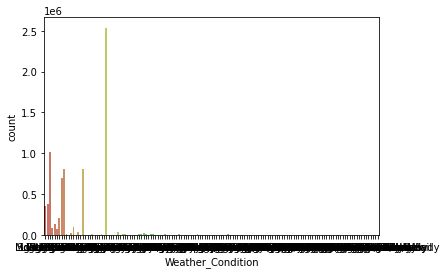

<Figure size 432x288 with 0 Axes>

In [12]:
sns.countplot(x='Weather_Condition', data=df, palette='hls')
plt.show()
plt.savefig('Weather Count Plot')

In [13]:
df['Weather_Condition'].value_counts()

Fair                           2537757
Mostly Cloudy                  1011099
Cloudy                          810005
Clear                           805167
Partly Cloudy                   694539
                                ...   
Heavy Sleet / Windy                  1
Dust Whirls                          1
Heavy Smoke                          1
Heavy Freezing Rain / Windy          1
Drifting Snow                        1
Name: Weather_Condition, Length: 143, dtype: int64

In [14]:
count_sev_1 = len(df[df['Severity']==1])
count_sev_2 = len(df[df['Severity']==2])
count_sev_3 = len(df[df['Severity']==3])
count_sev_4 = len(df[df['Severity']==4])

pct_sev_1 = count_sev_1/(count_sev_1+count_sev_2+count_sev_3+count_sev_4)
print("Level 1 severity:", "{0:.2f}%".format(pct_sev_1*100),"of total accidents")
pct_sev_2 = count_sev_2/(count_sev_1+count_sev_2+count_sev_3+count_sev_4)
print("Level 2 severity:", "{0:.2f}%".format(pct_sev_2*100),"of total accidents")
pct_sev_3 = count_sev_3/(count_sev_1+count_sev_2+count_sev_3+count_sev_4)
print("Level 3 severity:", "{0:.2f}%".format(pct_sev_3*100),"of total accidents")
pct_sev_4 = count_sev_4/(count_sev_1+count_sev_2+count_sev_3+count_sev_4)
print("Level 4 severity:", "{0:.2f}%".format(pct_sev_4*100),"of total accidents")

Level 1 severity: 0.88% of total accidents
Level 2 severity: 79.70% of total accidents
Level 3 severity: 16.84% of total accidents
Level 4 severity: 2.59% of total accidents


In [15]:
df.groupby('Severity').mean()

,Start_Lat,Start_Lng,Temperature(F),Humidity(%)
Severity,,,,
1,35.694503,-94.659939,72.448856,61.875078
2,36.039196,-95.069680,61.572254,64.661777
3,36.675217,-94.025756,62.223595,65.388889
4,37.856981,-88.618904,58.156160,67.319254


In [16]:
# Looking for correlations in the data
df.corr()

,Severity,Start_Lat,Start_Lng,Temperature(F),Humidity(%)
Severity,1.000000,0.069622,0.051299,-0.020290,0.022479
Start_Lat,0.069622,1.000000,-0.070047,-0.444249,0.022575
Start_Lng,0.051299,-0.070047,1.000000,-0.010261,0.179648
Temperature(F),-0.020290,-0.444249,-0.010261,1.000000,-0.331296
Humidity(%),0.022479,0.022575,0.179648,-0.331296,1.000000


As I start to explore the data, I want to literally map out the data 
I have used GeoDataFrame to map out Levels 1-4 Severity accidents to 
see if there are any noticeable geographic trends. The GeoDataFrame uses
the Starting Latitude and Longitude to pinpoint accident location. The 
mapping was a good exercise, but due to the sheer quantity of data, this 
did not provide any insight into geographic trends.

<AxesSubplot:>

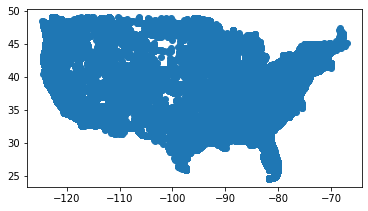

In [17]:
# Convert data to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
# then plotting  data - 
# Level 1 Severity
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df.loc[df['Severity']=='1'], crs=loc_crs, geometry=loc_geom)
geo_df.plot()

<AxesSubplot:>

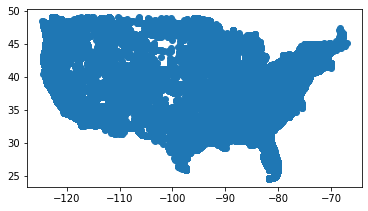

In [18]:
# Level 2 Severity
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df.loc[df['Severity']=='2'], crs=loc_crs, geometry=loc_geom)
geo_df.plot()

<AxesSubplot:>

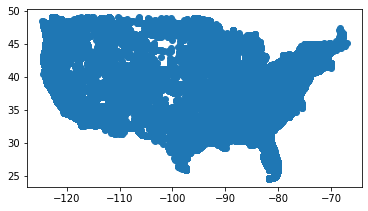

In [19]:
# Level 3 Severity
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df.loc[df['Severity']=='3'], crs=loc_crs, geometry=loc_geom)
geo_df.plot()

<AxesSubplot:>

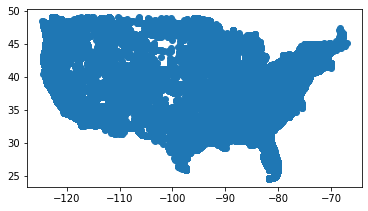

In [20]:
# Level 4 Severity
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df.loc[df['Severity']=='1'], crs=loc_crs, geometry=loc_geom)
geo_df.plot()

<AxesSubplot:>

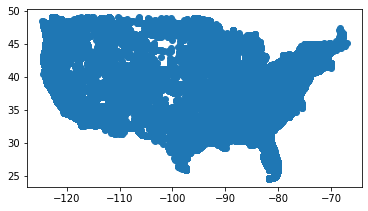

In [21]:
# Plotting for all severity levels together
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, crs=loc_crs, geometry=loc_geom)
geo_df.plot()

In [16]:
# Creating dummy variables for categorical variables
df = pd.concat((df, pd.get_dummies(df.Sunrise_Sunset)),1)
df.drop(['Sunrise_Sunset'], axis=1, inplace=True)

In [17]:
# Creating dummy variables for categorical variables
df = pd.concat((df, pd.get_dummies(df.Weather_Condition)), 1)
df.drop(['Weather_Condition'], axis = 1, inplace = True)

In [25]:
# Dropping the geometric point data in order to model
df.drop('geometry', axis=1, inplace=True)

In [18]:
# We are now going to get absolute values on any variable that has a negative value in the df
# While scaling will fix this to an extent, it does not help when it comes time for using the
# chi-squared metric for feature selection. To reduce re-work, we will proceed as below:
df['Start_Lat'] = df['Start_Lat'].abs()
df['Start_Lng'] = df['Start_Lng'].abs()
df['Temperature(F)'] = df['Temperature(F)'].abs()
df['Humidity(%)'] = df['Humidity(%)'].abs()   

In [19]:
# df has prepared data - saving df2 with original df as a placeholder
df2 = df

In [28]:
# Using resampling in order to address the balance issue, with Level 2 severity being significantly 
# higher than the other severities combined

from sklearn.utils import resample
 
# Put the majority class and minority class on separate dataframes
majority_df = df2[df2["Severity"]==2]
minority_df = df2[df2["Severity"]!=2]  
 
# Oversampling the minority class randomly
new_minority_df = resample(minority_df, replace = True, 
                            n_samples = len(majority_df), 
                            random_state = 0 )
 
# Combine the new minority class with the majority class
balanced_df = pd.concat([majority_df, new_minority_df])

In [29]:
# Target and Feature creation with 20% testing split
X = balanced_df.loc[ : , balanced_df.columns != 'Severity'] 
y = balanced_df.Severity 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

#### Decision Tree Model

In [30]:
# Creating and training Decision Tree classifier object
# Using that to predict response for test data
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Reporting model accuracy and creating a confusion matrix for the model prediction on the test set
print("Model Accuracy with Criterion Gini Index of {0:0.4f}". format(accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

# Accuracy is 92.5% which seems a bit high, but perhaps due to already disproportionately high 
# instances of losses of 2nd level Severity?

Model Accuracy with Criterion Gini Index of 0.9253
[[  50153    1480     205      41]
 [  11731 1046490  101524   34691]
 [    239   15400  974033    1240]
 [     45   10654    1248  140968]]


In [31]:
# Tree optimization
# Creating and training Decision Tree classifer object and using that to predict response for test data
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
# Model accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# We see here 55.5% which is significantly lower than our initial iteration of the model

Accuracy: 0.5533190078246397
[[      0   51555     324       0]
 [      0 1037949  156487       0]
 [      0  706350  284562       0]
 [      0  121465   31450       0]]


In [32]:
# Making predictions with our model
predictions = clf.predict(X_test)
print(predictions[:5])

# 5 predictions indicating the predicted severity of 5 losses
# We see all 2s, which may go back to the original concern that there are such a high proportion of
# losses rated a 2 in severity that a default assumption of 2 level severity is as good a guess as
# what the model shows - even after balancing the classes via resampling

[2 2 2 2 2]


[Text(0.5, 0.875, 'X[22] <= 0.5\nentropy = 1.399\nsamples = 9560566\nvalue = [206477, 4780918, 3964679, 608492]'),
 Text(0.25, 0.625, 'X[12] <= 0.5\nentropy = 1.37\nsamples = 6757760\nvalue = [100060, 3015687, 3216941, 425072]'),
 Text(0.125, 0.375, 'X[94] <= 0.5\nentropy = 1.385\nsamples = 5480403\nvalue = [99041, 2587652, 2450897, 342813]'),
 Text(0.0625, 0.125, 'entropy = 1.39\nsamples = 4862293\nvalue = [98643, 2389425, 2075020, 299205]'),
 Text(0.1875, 0.125, 'entropy = 1.239\nsamples = 618110\nvalue = [398, 198227, 375877, 43608]'),
 Text(0.375, 0.375, 'X[1] <= 117.03\nentropy = 1.234\nsamples = 1277357\nvalue = [1019, 428035, 766044, 82259]'),
 Text(0.3125, 0.125, 'entropy = 1.311\nsamples = 820167\nvalue = [627, 288815, 460084, 70641]'),
 Text(0.4375, 0.125, 'entropy = 1.054\nsamples = 457190\nvalue = [392, 139220, 305960, 11618]'),
 Text(0.75, 0.625, 'X[1] <= 110.687\nentropy = 1.365\nsamples = 2802806\nvalue = [106417, 1765231, 747738, 183420]'),
 Text(0.625, 0.375, 'X[1] <= 

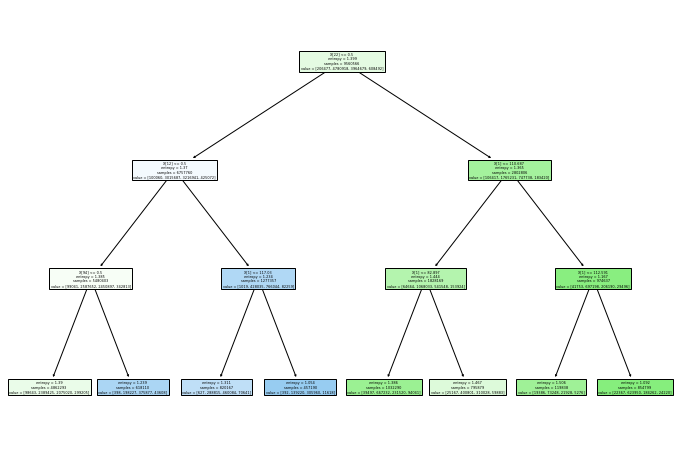

In [33]:
# Visualizing the Decision Tree

from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(clf.fit(X_train, y_train), filled=True)

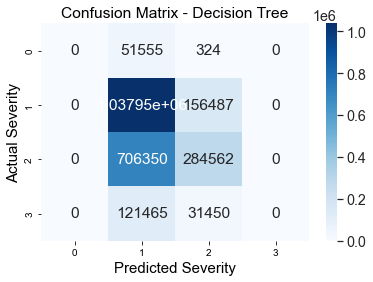

<Figure size 720x504 with 0 Axes>

In [34]:
# Visualizing with a Confusion Matrix
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt  

confusion_matrix = metrics.confusion_matrix(y_test,  y_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()

sns.set(font_scale=1.3)
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="Blues") 
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel('Predicted Severity', fontsize=15)
ax.set_ylabel('Actual Severity', fontsize=15)
plt.show()

In [35]:
# Chi-Squared metric to try to select the top 5 features:
sel5 = SelectKBest(score_func=chi2, k=5)
sel5.fit(balanced_df.fillna(0), y)
balanced_df.columns[sel5.get_support()].to_numpy()

array(['Severity', 'Start_Lng', 'Temperature(F)', 'Clear', 'Fair'],
      dtype=object)

In [36]:
# Create a feature list from our dataframe
feature_list = list(balanced_df.columns)

# Getting numerical feature importance:
importances = list(clf.feature_importances_)

# List of tuples with variables and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sorting the feature importance in descending order by importance
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Printing the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Note - This is different from the previous list of top features, and this actually
# accounts for the fact that Severity itself should be removed from the calculation.
# This helps us see that weather conditions and location (as latitude) do play a part
# in determining severity

Variable: Duststorm            Importance: 0.49
Variable: Start_Lat            Importance: 0.23
Variable: Blowing Snow Nearby  Importance: 0.16
Variable: N/A Precipitation    Importance: 0.12
Variable: Severity             Importance: 0.0
Variable: Start_Lng            Importance: 0.0
Variable: Temperature(F)       Importance: 0.0
Variable: Humidity(%)          Importance: 0.0
Variable: Day                  Importance: 0.0
Variable: Night                Importance: 0.0
Variable: Blowing Dust         Importance: 0.0
Variable: Blowing Dust / Windy Importance: 0.0
Variable: Blowing Sand         Importance: 0.0
Variable: Blowing Snow         Importance: 0.0
Variable: Blowing Snow / Windy Importance: 0.0
Variable: Clear                Importance: 0.0
Variable: Cloudy               Importance: 0.0
Variable: Cloudy / Windy       Importance: 0.0
Variable: Drifting Snow        Importance: 0.0
Variable: Drifting Snow / Windy Importance: 0.0
Variable: Drizzle              Importance: 0.0
Variable

In [37]:
# Use top 5 features with Decision Tree

top5 = sel5.transform(balanced_df)
top5 = pd.DataFrame(top5)

In [38]:
# Model Accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(top5, y, test_size=0.2)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Model Accuracy with index of {0:0.4f}". format(accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

# Here we see that when we limit to 5 variables we get an index score of 1.0 which means
# that there is no relationship between the variables - that is the results are possibly
# totally random using the model as-is

Model Accuracy with index of 1.0000
[[  51558       0       0       0]
 [      0 1194862       0       0]
 [      0       0  991324       0]
 [      0       0       0  152398]]


In [39]:
# Evaluate the Decision Tree that used top 5 features

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     51558
           2       1.00      1.00      1.00   1194862
           3       1.00      1.00      1.00    991324
           4       1.00      1.00      1.00    152398

    accuracy                           1.00   2390142
   macro avg       1.00      1.00      1.00   2390142
weighted avg       1.00      1.00      1.00   2390142



### References:

Kashnitsky, Yuri. “Logistic Regression-Tf-IDF Baseline.” Kaggle, Kaggle, 22 May 2019, https://www.kaggle.com/code/kashnitsky/logistic-regression-tf-idf-baseline/notebook.

Koehrson, Will. “Random Forest in Python - towards Data Science.” Towards Data Science, 27 Dec. 2017, https://towardsdatascience.com/random-forest-in-python-24d0893d51c0.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. Moosavi, Sobhan. “US Accidents (2016 - 2021).” Kaggle, 12 Mar. 2022, https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents., arXiv preprint arXiv:1906.05409 (2019).

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. Moosavi, Sobhan. “US Accidents (2016 - 2021).” Kaggle, 12 Mar. 2022, https://www.kaggle.com/datasets/sobhanmoosavi/us -accidents. In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.